In [1]:
!git clone 'https://github.com/aakashvardhan/s7-in-depth-practice.git'

Cloning into 's7-in-depth-practice'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 193 (delta 102), reused 152 (delta 61), pack-reused 0
Receiving objects: 100% (193/193), 572.99 KiB | 19.10 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [2]:
import sys
sys.path.append('/content/s7-in-depth-practice')
sys.path.append('/content/s7-in-depth-practice/models')

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from model_utils import model_summary, test_model_sanity, sgd_optimizer
from models.model import model3

from utils import train, test, get_device, plt_fig, get_incorrect_predictions, plot_incorrect

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.Resize((28, 28)),
                                      transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                                      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train_data = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 280526505.30it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41399758.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 192729110.37it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 8011155.92it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# CUDA?
cuda = get_device()

# For reproducibility
torch.manual_seed(1)

if torch.cuda.is_available():
    torch.cuda.manual_seed(1)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
model3 = model3().to(cuda)

In [8]:
model_summary(model3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
              ReLU-2            [-1, 4, 26, 26]               0
       BatchNorm2d-3            [-1, 4, 26, 26]               8
           Dropout-4            [-1, 4, 26, 26]               0
         ConvBlock-5            [-1, 4, 26, 26]               0
            Conv2d-6            [-1, 8, 24, 24]             288
              ReLU-7            [-1, 8, 24, 24]               0
       BatchNorm2d-8            [-1, 8, 24, 24]              16
           Dropout-9            [-1, 8, 24, 24]               0
        ConvBlock-10            [-1, 8, 24, 24]               0
           Conv2d-11           [-1, 16, 22, 22]           1,152
             ReLU-12           [-1, 16, 22, 22]               0
      BatchNorm2d-13           [-1, 16, 22, 22]              32
          Dropout-14           [-1, 16,

In [9]:
from torch.optim.lr_scheduler import StepLR


optimizer = sgd_optimizer(model3, 0.04)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
EPOCHS = 15
lr = []
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model3, cuda, train_loader, optimizer, epoch)
    test(model3, cuda, test_loader)
    scheduler.step()
    lr.append(optimizer.param_groups[0]['lr'])

EPOCH: 1


Loss=0.1004672646522522 Batch_id=468 Accuracy=86.27: 100%|██████████| 469/469 [00:45<00:00, 10.38it/s]



Test set: Average loss: 0.0586, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.15264847874641418 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:39<00:00, 11.92it/s]



Test set: Average loss: 0.0359, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.02856213040649891 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:40<00:00, 11.59it/s]



Test set: Average loss: 0.0347, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.12054858356714249 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:38<00:00, 12.04it/s]



Test set: Average loss: 0.0273, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.11410161107778549 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:38<00:00, 12.07it/s]



Test set: Average loss: 0.0269, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.08166797459125519 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:40<00:00, 11.60it/s]



Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.042961981147527695 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:39<00:00, 11.95it/s]



Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.024837957695126534 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:39<00:00, 11.87it/s]



Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.02000410668551922 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:40<00:00, 11.63it/s]



Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


Loss=0.0471225269138813 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:38<00:00, 12.03it/s]



Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.10331092029809952 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:39<00:00, 12.01it/s]



Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.034593913704156876 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:40<00:00, 11.72it/s]



Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.05399972200393677 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:39<00:00, 11.81it/s]



Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.012136869132518768 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:40<00:00, 11.62it/s]



Test set: Average loss: 0.0182, Accuracy: 9937/10000 (99.37%)

EPOCH: 15


Loss=0.03184324875473976 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:39<00:00, 11.89it/s]



Test set: Average loss: 0.0185, Accuracy: 9942/10000 (99.42%)



In [10]:
# Save model
torch.save(model3.state_dict(), 'best_model.pth')

In [12]:
[train_loss.cpu().detach().numpy() for train_loss in train_losses]

[array(2.308262, dtype=float32),
 array(2.298224, dtype=float32),
 array(2.30002, dtype=float32),
 array(2.2905009, dtype=float32),
 array(2.2817128, dtype=float32),
 array(2.2599704, dtype=float32),
 array(2.2666545, dtype=float32),
 array(2.2379963, dtype=float32),
 array(2.2241728, dtype=float32),
 array(2.1850176, dtype=float32),
 array(2.1743488, dtype=float32),
 array(2.1517124, dtype=float32),
 array(2.131237, dtype=float32),
 array(2.0989072, dtype=float32),
 array(2.0232508, dtype=float32),
 array(2.105223, dtype=float32),
 array(2.0442336, dtype=float32),
 array(2.0455568, dtype=float32),
 array(1.9970168, dtype=float32),
 array(1.9058263, dtype=float32),
 array(2.0223765, dtype=float32),
 array(1.7959633, dtype=float32),
 array(1.760432, dtype=float32),
 array(1.837059, dtype=float32),
 array(1.8323207, dtype=float32),
 array(1.688452, dtype=float32),
 array(1.7906767, dtype=float32),
 array(1.6203911, dtype=float32),
 array(1.6230288, dtype=float32),
 array(1.6646743, dtype

Text(0.5, 1.0, 'Test Accuracy')

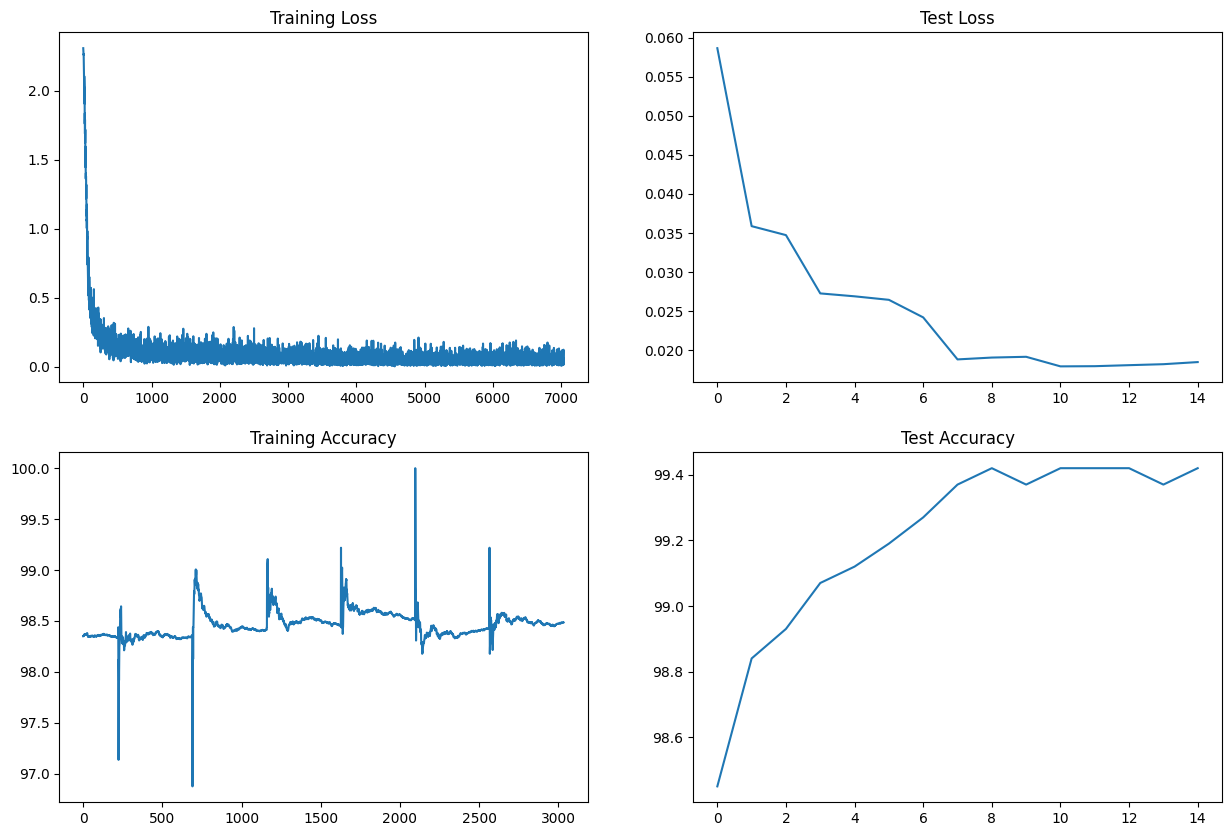

In [13]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([train_loss.cpu().detach().numpy() for train_loss in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")